In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import datetime

def obtener_tiempo(dfr):
    #Esta funcion permite obtener una columna Datetime a partir del agno, dia, hora y minuto de los datos iniciales
    dfr['Day'] = pd.to_datetime(dfr['Day'], format='%j').dt.strftime('%m-%d')
    dfr['Hour'] = dfr['Hour'].astype(str).str.zfill(2)
    dfr['Datetime'] = pd.to_datetime(dfr[['Year','Day', 'Hour', 'Minute']]
                   .astype(str).apply(' '.join, 1), format='%Y %m-%d %H %M') 
    return dfr

def sustituir(dfr):
    #Sustitucion de los valores 9999... por NaN (sabemos que la fila 2 son todo valores nulos para cada variable)
    valores_null = dfr.iloc[2, 4:]
    for i in range(len(valores_null)):
        dfr.iloc[:,i+4] = dfr.iloc[:,i+4].replace(valores_null[i], np.nan)
    return dfr

def imputar_por_interpolacion(dfr):
    #Sustituye los valores NaN por valores aproximados mediante el metodo de interpolacion
    dfr = dfr.interpolate(method='linear', limit_direction='forward')
    return dfr

def imputar_por_KNND(dfr):
    #Este metodo es para imputar las filas que no se hayan podido imputar con interpolacion (primera fila)
    imputer = KNNImputer(n_neighbors=3, weights = 'distance')
    dfr[:] = imputer.fit_transform(dfr)
    return dfr

def normalizar_datos_standardScaler(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def normalizar_datos_MinMaxScaler(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    minmax_scaler = preprocessing.MinMaxScaler()
    dfr[:] = minmax_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def desnormalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores desnormalizados
    x = dfr.values
    min_max_scaler = preprocessing.MinMaxScaler()
    dfr[:] = min_max_scaler.inverse_transform(x)
    return dfr

def preprocesar(df):
  df = sustituir(df)
  df = imputar_por_interpolacion(df)
  df = imputar_por_KNND(df.iloc[:3, :])
  df = obtener_tiempo(df)
  df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
  df = df.set_index('Datetime')

#**1-Montamos Drive para poder acceder a los datos y los leemos**

In [ ]:
#Leemos los datos
#df = pd.read_csv('datos.csv', header=0)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFG_codigo/Prediccion_general/datos.csv', header=0)

#**2-Preprocesamos los datos y los normalizamos**

In [ ]:
#2-Preprocesamos los datos
df = sustituir(df)
#df = imputar_por_interpolacion(df)
#imputar_por_KNND(df.iloc[:3, :])
df.fillna(method='ffill', inplace=True)
df = obtener_tiempo(df)
df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
df = df.set_index('Datetime')
df['tormenta'] = 500
#df = normalizar_datos_standardScaler(df) #Los datos se deben normalizar despues de la division de datos
df

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K),tormenta
Datetime,,,,,,,,
1995-01-01 00:00:00,1.37,0.13,1.17,-0.67,NaN,NaN,NaN,500
1995-01-01 00:05:00,1.26,0.09,1.12,-0.50,311.4,18.46,17347.0,500
1995-01-01 00:10:00,1.26,0.09,1.12,-0.50,311.4,18.46,17347.0,500
1995-01-01 00:15:00,1.26,0.09,1.12,-0.50,311.4,18.46,17347.0,500
1995-01-01 00:20:00,1.26,0.09,1.12,-0.50,311.4,18.46,17347.0,500
...,...,...,...,...,...,...,...,...
2021-02-18 23:35:00,2.87,2.13,0.03,-1.86,364.1,4.67,58514.0,500
2021-02-18 23:40:00,2.92,2.21,0.07,-1.88,364.9,4.40,62883.0,500
2021-02-18 23:45:00,2.90,2.45,0.05,-1.54,364.1,4.65,58624.0,500


#**3-Fechas de tormentas geomagnéticas**

In [ ]:
#ORIGINAL
TRAINING_STORMS_DATES_START = ['19980214', '19980802', '19980919', '19990216', '19991015', '20000709', '20000806', '20000915', '20001101',
                               '20010314', '20010406', '20011017', '20011031', '20020517', '20031115', '20040720', '20050510', '20060409', '20061209', '20120301']
TRAINING_STORMS_DATES_END = ['199802222359', '199808082359', '199809292359', '199902242359', '199910252359', '200007192359', '200008162359', '200009252359', '200011152359',
                             '200103242359', '200104162359', '200110222359', '200111102359', '200205272359', '200311252359', '200407302359', '200505202359', '200604192359', '200612192359', '201203112359']

VALIDATION_STORMS_DATES_START = [
    '19980428', '19990919', '20031025', '20150618', '20170901']
VALIDATION_STORMS_DATES_END = [
    '199805082359', '199909262359', '200311032359', '201506282359', '201709112359']

TESTING_STORMS_DATES_START = ['19980622', '19981102', '19990109', '19990413', '20000116', '20000402', '20000519',
                              '20010326', '20030526', '20030708', '20040118', '20041104', '20120910', '20130528', '20130626', '20150311', '20180822']
TESTING_STORMS_DATES_END = ['199806302359', '199811122359', '199901182359', '199904192359', '200001262359', '200004122359', '200005282359', '200104042359',
                            '200306062359', '200307182359', '200401272359', '200411142359', '201210052359', '201306042359', '201307042359', '201503212359', '201809032359']

**3.1-Definición de funciones para split de datos**

In [ ]:
def split_tormentas(df, train_start_dates = TRAINING_STORMS_DATES_START, train_end_dates = TRAINING_STORMS_DATES_END,
                    val_start_dates = VALIDATION_STORMS_DATES_START, val_end_dates = VALIDATION_STORMS_DATES_END, test_start_dates = TESTING_STORMS_DATES_START, test_end_dates = TESTING_STORMS_DATES_END):
  
  indice_tormenta = 0
  
  tormentas_train = []
  tormentas_val   = []
  tormentas_test  = []

  for start, end in zip(train_start_dates, train_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_train.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  for start, end in zip(val_start_dates, val_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_val.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  for start, end in zip(test_start_dates, test_end_dates):
    tormenta = df.loc[start:end].copy()
    tormenta['tormenta'] = indice_tormenta
    tormentas_test.append(tormenta)
    indice_tormenta = indice_tormenta + 1

  df_train = tormentas_train[0]
  df_val   = tormentas_val[0]
  df_test  = tormentas_test[0]

  for tormenta in range(len(tormentas_train)):
    if(tormenta != 0):
      df_train = pd.concat((df_train, tormentas_train[tormenta]))

  for tormenta in range(len(tormentas_val)):
    if(tormenta != 0):
      df_val = pd.concat((df_val, tormentas_val[tormenta]))

  for tormenta in range(len(tormentas_test)):
    if(tormenta != 0):
      df_test = pd.concat((df_test, tormentas_test[tormenta]))
  

  return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = split_tormentas(df)

df_train.set_index('tormenta', append=True, inplace=True)
df_val.set_index('tormenta', append=True, inplace=True)
df_test.set_index('tormenta', append=True, inplace=True)

df_train = df_train.reorder_levels(['tormenta', 'Datetime'])
df_val = df_val.reorder_levels(['tormenta', 'Datetime'])
df_test = df_test.reorder_levels(['tormenta', 'Datetime'])


df_train

IMF(nT)  ...  Proton Temperature(K)
tormenta Datetime                      ...                       
0        1998-02-14 00:00:00     5.08  ...                40709.0
         1998-02-14 00:05:00     4.97  ...                57155.0
         1998-02-14 00:10:00     4.91  ...                58182.0
         1998-02-14 00:15:00     4.84  ...                50818.0
         1998-02-14 00:20:00     4.83  ...                61568.0
...                               ...  ...                    ...
19       2012-03-11 23:35:00     4.02  ...                15275.0
         2012-03-11 23:40:00     4.02  ...                15159.0
         2012-03-11 23:45:00     3.92  ...                19729.0
         2012-03-11 23:50:00     3.84  ...                18412.0
         2012-03-11 23:55:00     3.85  ...                 8306.0

[60768 rows x 7 columns]

NORMALIZACION CON STANDARDSCALER

In [ ]:
df_train = normalizar_datos_standardScaler(df_train)
df_val = normalizar_datos_standardScaler(df_val)
df_test = normalizar_datos_standardScaler(df_test)

In [ ]:
df_train.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,6.076800e+04,6.076800e+04,6.076800e+04,6.076800e+04,6.076800e+04,6.076800e+04,6.076800e+04
mean,3.934360e-16,8.195577e-16,7.451510e-16,7.143997e-16,-2.681322e-15,2.395981e-15,1.198572e-15
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.317148e+00,-8.636086e+00,-5.333780e+00,-9.444638e+00,-1.812483e+00,-1.069130e+00,-7.562960e-01
25%,-5.727157e-01,-6.489607e-01,-5.543221e-01,-3.886166e-01,-7.902657e-01,-6.004601e-01,-5.190744e-01
50%,-3.281164e-01,6.968042e-02,-5.871096e-02,3.819290e-02,-1.823113e-01,-2.811917e-01,-2.655374e-01
75%,1.858967e-01,7.022447e-01,4.679781e-01,4.759462e-01,6.485860e-01,2.284099e-01,1.860856e-01
max,8.511136e+00,6.395324e+00,6.974714e+00,6.283473e+00,4.566690e+00,1.063329e+01,2.996140e+01


In [ ]:
df_val.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,1.468800e+04,1.468800e+04,1.468800e+04,1.468800e+04,1.468800e+04,1.468800e+04,1.468800e+04
mean,2.214785e-15,7.157930e-15,4.299195e-15,-7.281284e-16,-6.411022e-15,-5.316319e-15,9.930857e-16
std,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00,1.000034e+00
min,-1.547870e+00,-6.385528e+00,-6.526159e+00,-7.249298e+00,-1.805914e+00,-7.608392e-01,-7.004616e-01
25%,-6.639755e-01,-7.528239e-01,-5.596426e-01,-4.654094e-01,-7.066670e-01,-4.735645e-01,-5.510722e-01
50%,-3.045669e-01,9.047928e-02,-1.826813e-02,-6.074305e-02,-1.750698e-01,-3.172532e-01,-3.595283e-01
75%,4.936547e-01,6.633645e-01,5.952896e-01,4.355459e-01,5.640160e-01,1.085955e-02,4.402798e-02
max,7.589886e+00,4.248905e+00,5.965344e+00,6.305117e+00,3.581428e+00,8.792454e+00,1.626549e+01


In [ ]:
df_test.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,5.472000e+04,5.472000e+04,5.472000e+04,5.472000e+04,5.472000e+04,5.472000e+04,5.472000e+04
mean,-1.166905e-15,-3.284065e-16,2.360320e-16,7.930907e-17,9.958895e-16,2.072092e-16,6.537777e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.265629e+00,-1.109721e+01,-9.139038e+00,-9.085666e+00,-1.738710e+00,-1.076097e+00,-9.708135e-01
25%,-5.534856e-01,-7.043469e-01,-5.610906e-01,-3.699972e-01,-7.536854e-01,-6.019889e-01,-6.441225e-01
50%,-2.690152e-01,-1.194454e-02,-5.203616e-02,4.906151e-02,-3.026158e-01,-2.847148e-01,-2.984078e-01
75%,1.838152e-01,7.169000e-01,5.178009e-01,4.380532e-01,6.789186e-01,2.452771e-01,3.278259e-01
max,1.250700e+01,6.545379e+00,1.014805e+01,1.000311e+01,3.811976e+00,1.031152e+01,1.163623e+01


NORMALIZACION CON MINMAXSCALER

In [ ]:
df_train = normalizar_datos_MinMaxScaler(df_train)
df_val   = normalizar_datos_MinMaxScaler(df_val)
df_test  = normalizar_datos_MinMaxScaler(df_test)

In [ ]:
df_train.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000,60768.000000
mean,0.134016,0.574536,0.433341,0.600494,0.284125,0.091360,0.024621
std,0.101748,0.066528,0.081245,0.063581,0.156761,0.085453,0.032555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.075744,0.531362,0.388306,0.575786,0.160243,0.040049,0.007723
50%,0.100631,0.579172,0.428571,0.602922,0.255546,0.067331,0.015976
75%,0.152931,0.621254,0.471362,0.630755,0.385797,0.110878,0.030679
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_val.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,14688.000000,14688.000000,14688.000000,14688.000000,14688.000000,14688.000000,14688.000000
mean,0.169393,0.600458,0.522448,0.534829,0.335214,0.079642,0.041286
std,0.109440,0.094037,0.080057,0.073779,0.185627,0.104680,0.058944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.096730,0.529667,0.477646,0.500493,0.204043,0.030071,0.008805
50%,0.136062,0.608966,0.520985,0.530348,0.302718,0.046433,0.020095
75%,0.223416,0.662837,0.570103,0.566962,0.439907,0.080778,0.043881
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_test.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,54720.000000,54720.000000,54720.000000,54720.000000,54720.000000,54720.000000,54720.000000
mean,0.091895,0.629001,0.473842,0.475969,0.313242,0.094497,0.077006
std,0.072608,0.056682,0.051849,0.052387,0.180160,0.087815,0.079321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051707,0.589078,0.444751,0.456586,0.177460,0.041634,0.025913
50%,0.072362,0.628324,0.471144,0.478539,0.258724,0.069495,0.053336
75%,0.105241,0.669636,0.500689,0.498917,0.435555,0.116036,0.103009
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#4-Creación de datasets

In [ ]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]





def timeseries_dataset_from_df1(df, window_entrada = 40, window_salida = 4):
    dataset_x_total = None    
    dataset_y_total = None

    start_ind = 0
    step = 1
    for indice_tormenta, datos_tormenta in df.groupby("tormenta"):
        dataset_x , dataset_y = multivariate_multioutput_data(
            datos_tormenta.values,
            datos_tormenta.values, 
            start_ind,
            None,
            window_entrada,
            window_salida,
            step)

        if dataset_x_total is None:
            dataset_x_total = dataset_x
            dataset_y_total = dataset_y 
        else:
            dataset_x_total = np.concatenate((dataset_x_total, dataset_x))
            dataset_y_total = np.concatenate((dataset_y_total, dataset_y))

    return dataset_x_total, dataset_y_total

In [ ]:
#OBTENEMOS LOS datasets x e y
x_train , y_train = timeseries_dataset_from_df1(df_train)
x_val , y_val     = timeseries_dataset_from_df1(df_val)
x_test , y_test   = timeseries_dataset_from_df1(df_test)


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(2).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(2).repeat()


test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.cache().batch(2).repeat()

**Forma de los datasets**

In [ ]:
print (x_train.shape,
       y_train.shape,
       x_val.shape,
       y_val.shape,
       x_test.shape,
       y_test.shape,
       'Single window of past history : {}'.format(x_train[0].shape),
       'Target temperature to predict : {}'.format(y_train[0].shape),
       sep='\n')

(59888, 40, 7, 1, 1)
(59888, 4, 7, 1, 1)
(14468, 40, 7, 1, 1)
(14468, 4, 7, 1, 1)
(53972, 40, 7, 1, 1)
(53972, 4, 7, 1, 1)
Single window of past history : (40, 7, 1, 1)
Target temperature to predict : (4, 7, 1, 1)


#5-CARGAMOS LOS MODELOS

**MODELO BASELINE**

In [ ]:
#codigo baseline
def baseline(x_val, y_val):
  num_predicciones = len(y_val)
  timesteps_futuros = len(y_val[0])
  timesteps_pasados = len(x_val[0])
  variables = len(x_val[0][0])
  predicciones = np.zeros(shape=(y_val.shape))
  for prediccion in range(num_predicciones):
      dato = x_val[prediccion][timesteps_pasados-1]
      for num_timesteps_a_predecir in range(timesteps_futuros):
          predicciones[prediccion][num_timesteps_a_predecir] = dato
  return predicciones


**MODELO SIMPLE**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_simplificado(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO COMPLEJO**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_complejo(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=0.008, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO COMPLEJO SIMPLIFICADO** El número de parámetros optimos para resolver un problema en función del tamaño del dataset = 2 veces el dataset + d, es decir, algo más que dos veces el dataset. En nuestro caso, antes teníamos un dataset de 2.3 millones de datos, pero ahora es de unos 2

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_complejo(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 32, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 32, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 32)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 32, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 32, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=0.008, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**CARGAMOS EL MODELO COMPLEJO DE LAS PREDICCIONES GENERALES**

In [ ]:
model_c = build_model_complejo(x_train.shape[1], y_train.shape[1], y_train.shape[2], x_train.shape[2])
model_c.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_pesos.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
predicciones_c = model_c.predict(x_test, verbose=1)

1687/1687 [==============================] - 102s 61ms/step


In [ ]:
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/predicciones_tormenta', predicciones_c)
predicciones_c = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/predicciones_tormenta.npy')

In [ ]:
predicciones_baseline = baseline(x_test, y_test)

In [ ]:
predicciones   = [predicciones_baseline, predicciones_c]
nombre_modelos = ['Baseline', 'Complejo']
variables      = df_train.columns

In [ ]:
variables

Index(['IMF(nT)', 'Bx GSM(nT)', 'By GSM(nT)', 'Bz GSM(nT)', 'Flow Speed(km/s)',
       'Proton Density(n/cc)', 'Proton Temperature(K)'],
      dtype='object')

#5.1-Entrenamiento del modelo complejo

In [ ]:
#Crear y entrenar modelo
#/content/drive/MyDrive/TFG_codigo/modelo_simplificado_100epochs.h5
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
EPOCHS = 5
steps_per_epoch = 350
validation_steps = 500

path_checkpoint = "/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c2_probador_weights.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 50, restore_best_weights=True)
model_c = build_model_complejo(x_train.shape[1], 4, y_train.shape[2], x_train.shape[2])
print(model_c.summary())

# Train
print("\nTRAIN MODEL...")
history = model_c.fit(train_data,
                    epochs = 5,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping, modelckpt_callback])

#GUARDAMOS EL MODELO
from keras.models import load_model
model_c.save('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_probador_modelo.h5')
import pickle
#GUARDAMOS EL HISTORY
with open('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_probador', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 40, 7, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 7, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 40, 7, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 7, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 7, 1, 64)         

**ENTRENAMIENTO MODELO COMPLEJO PERO SIMPLIFICADO**

In [ ]:
#Crear y entrenar modelo
#/content/drive/MyDrive/TFG_codigo/modelo_simplificado_100epochs.h5
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
EPOCHS = 5
steps_per_epoch = 350
validation_steps = 500

path_checkpoint = "/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_S2_probador_weights.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 50, restore_best_weights=True)
model_c = build_model_complejo(x_train.shape[1], 4, y_train.shape[2], x_train.shape[2])
print(model_c.summary())

# Train
print("\nTRAIN MODEL...")
history = model_c.fit(train_data,
                    epochs = 20,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping, modelckpt_callback])

#GUARDAMOS EL MODELO
from keras.models import load_model
model_c.save('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_S_2_probador_modelo.h5')
import pickle
#GUARDAMOS EL HISTORY
with open('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_S_2_probador', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 7, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 40, 7, 1, 32)      42368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 7, 1, 32)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 40, 7, 1, 32)      128       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 7, 1, 32)          41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 1, 32)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 7, 1, 32)         

In [ ]:
predicciones_c_probador = model_c.predict(x_test, verbose=1)

1687/1687 [==============================] - 103s 61ms/step


**5.2-CARGAMOS LOS MODELOS**

In [ ]:
import pickle
from keras.models import load_model
model_c = load_model('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_probador_modelo.h5'')
history_c = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_probador', "rb"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
modelo_c.weights

#4-Evaluación de los modelos y comparativa

In [ ]:
def plot_train_history(history, title):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

**4.1-Históricos de los modelos orientados a predicción general**

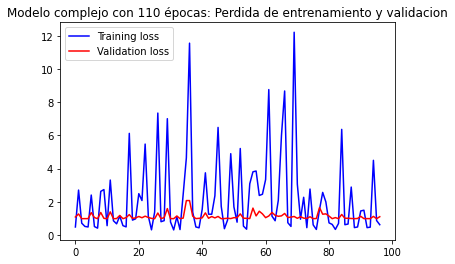

In [ ]:
#Modelos todas variables
#plot_train_history(history_s, 'Modelo simple con 100 épocas: Perdida de entrenamiento y validacion')
plot_train_history(history_c, 'Modelo complejo con 110 épocas: Perdida de entrenamiento y validacion')

**4.2.1-Predición de modelo complejo y baseline**

In [ ]:
#Obtneemos las predicciones de los modelos Bz y By
variables = df.columns
predicciones_c = modelo_c.predict(x_test, verbose=1)
predicciones_baseline = baseline(x_test, y_test)

1687/1687 [==============================] - 101s 60ms/step


In [ ]:
predicciones_c.shape, predicciones_baseline.shape

**4.2.1.1Guardamos las predicciones**

In [ ]:
#Guardamos las predicciones realizadas
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_predicciones', predicciones_c)
#np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/baseline_predicciones', predicciones_baseline)

**4.2.1.2-Cargar las predicciones calculadas**

In [ ]:
predicciones_c        = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/model_c_2_predicciones.npy')
predicciones_baseline = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_tormentas/Modelo_C/baseline_predicciones.npy')

In [ ]:
predicciones_baseline = baseline(x_test, y_test)

In [ ]:
predicciones   = [predicciones_baseline, predicciones_c]
nombre_modelos = ['Baseline', 'Complejo']
variables      = df_train.columns

In [ ]:
predicciones   = [predicciones_baseline, predicciones_c_probador]
nombre_modelos = ['Baseline', 'Complejo']
variables      = df_train.columns

**4.2.2.1-Guardamos las predicciones de los modelos realizadas**

**4.3-Comparativa de los modelos**

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def obtener_metricas(y_val, y_preds, nombre_modelos):
    #Aplanamos los datos para que se puedan calcular las metricas
    y_val = np.squeeze(y_val)
    y_val = y_val.ravel()
    datos_mse  = []
    datos_r2   = []
    datos_rmse = []
    datos_mae  = []
    columnas   = []
    for modelo in range(len(nombre_modelos)):
        y_pred = np.squeeze(y_preds[modelo])
        y_pred = y_pred.ravel()
        #Calculamos las metricas
        r2   = r2_score(y_val, y_pred)
        mse  = mean_squared_error(y_val, y_pred)
        mae  = mean_absolute_error(y_val, y_pred)
        rmse = mse**0.5
        #Los anadimos a las listas correspondientes
        datos_mse.append(mse)
        datos_r2.append(r2)
        datos_rmse.append(rmse)
        datos_mae.append(mae)
        #Creamos una columna por modelo
        columnas.append(nombre_modelos[modelo])

    #Mostramos los resultados en forma de df
    nombres_metricas = ['R2', 'RMSE', 'MSE', 'MAE']
    valores = [datos_r2, datos_rmse, datos_mse, datos_mae]

    metricas = pd.DataFrame(valores, columns = columnas, index = nombres_metricas)
    return metricas



def desglose_por_timestep(y_val, predicciones):
    num_predicciones = predicciones.shape[0]
    num_timesteps   = predicciones.shape[1]

    timesteps_y_val  = []
    timesteps_y_pred = []
    
    #Creamos 4 listas, una para cada timestep
    for lista_timestep in range(num_timesteps):
        timestep_valN = []
        timesteps_y_val.append(timestep_valN)
        timestep_predN = []
        timesteps_y_pred.append(timestep_predN)
    #Metemos en cada una de los 4 listas, el correspondiente timestep de cada prediccion
    for prediccion in range(num_predicciones):
        for timestep in range(num_timesteps):
            timesteps_y_pred[timestep].append(predicciones[prediccion][timestep])
            timesteps_y_val[timestep].append(y_val[prediccion][timestep])
    
    return timesteps_y_val, timesteps_y_pred

def comparacion_modelos_timestep(y_val, predicciones, nombre_modelos):
  timesteps = y_val.shape[1]

  timesteps_y_preds = []

  for modelo in range(len(nombre_modelos)):
      timesteps_y_val, timesteps_y_pred_modelo = desglose_por_timestep(y_val, predicciones[modelo])
      timesteps_y_preds.append(timesteps_y_pred_modelo)
  for timestep in range(timesteps):
      timesteps_modelos = []
      for modelo in range(len(nombre_modelos)):
          timesteps_modelos.append(timesteps_y_preds[modelo][timestep])
      print("=========TIMESTEP: ",timestep,"=========\n",obtener_metricas(timesteps_y_val[timestep], timesteps_modelos, nombre_modelos))


def comparacion_modelos_timestep_variables(y_val, predicciones, nombre_modelos, nombre_variables):
  timesteps = y_val.shape[1]

  desglose_preds = []
  for modelo in range(len(nombre_modelos)):
      desglose_val, desglose_pred = agrupar_variables_timestep(y_val, predicciones[modelo])
      desglose_preds.append(desglose_pred)
  
  for paso in range(timesteps):
    print("===================TIMESTEP ", paso,"===================")
    for variable in range(len(nombre_variables)):
        variableN_modelos = []
        for modelo in range(len(nombre_modelos)):
          variableN_modelos.append(desglose_preds[modelo][paso][variable])
        print("=====VARIABLE", nombre_variables[variable],"====")
        print(obtener_metricas(desglose_val[paso][variable], variableN_modelos, nombre_modelos))


def agrupar_variables_timestep(y_val, y_pred):
    num_predicciones = y_val.shape[0]
    num_timesteps    = y_val.shape[1]
    num_variables    = y_val.shape[2]
    #Creacion de listas
    desglose_val  = []
    desglose_pred = []
    for paso in range(num_timesteps):
        timestepN_val  = []
        timestepN_pred = []
        for i in range(num_variables):
            timestepN_varI_val = []
            timestepN_val.append(timestepN_varI_val)
            
            timestepN_varI_pred = []
            timestepN_pred.append(timestepN_varI_pred)
            
        desglose_val.append(timestepN_val)
        desglose_pred.append(timestepN_pred)
    
    #Desglose
    for prediccion in range(num_predicciones):
        for paso in range(num_timesteps):
            for var in range(num_variables):
                desglose_val[paso][var].append(y_val[prediccion][paso][var])
                desglose_pred[paso][var].append(y_pred[prediccion][paso][var])
    
    return desglose_val, desglose_pred




def resumen_comparativa(y_val, predicciones, nombre_modelos, variables):
    pd.set_option("display.max_rows", None, "display.max_columns", None)

    #1-Comparativa general de los modelos
    print("===================================================COMPARATIVA GENERAL DE LOS MODELOS===================================================")
    print(obtener_metricas(y_val, predicciones, nombre_modelos))

    #2-Comparativa por timestep de los modelos
    print("===================================================COMPARATIVA POR TIMESTEP DE LOS MODELOS===================================================")
    print(comparacion_modelos_timestep(y_val, predicciones, nombre_modelos))

    print("===================================================COMPARATIVA POR TIMESTEP Y VARIABLES DE LOS MODELOS===================================================")
    #3-Comparativa por timestep y variable de los modelos
    print(comparacion_modelos_timestep_variables(y_val, predicciones, nombre_modelos, variables))


In [ ]:
predicciones_c_probador[0]

array([[[[0.08847772]],

        [[0.56465924]],

        [[0.4530117 ]],

        [[0.5550755 ]],

        [[0.08847772]],

        [[0.08847772]],

        [[0.08847772]]],


       [[[0.08847772]],

        [[0.5718351 ]],

        [[0.4491843 ]],

        [[0.5471088 ]],

        [[0.08847772]],

        [[0.08847772]],

        [[0.08847772]]],


       [[[0.08847772]],

        [[0.5783713 ]],

        [[0.4570421 ]],

        [[0.5512754 ]],

        [[0.08847772]],

        [[0.08847772]],

        [[0.08847772]]],


       [[[0.08847772]],

        [[0.5791463 ]],

        [[0.45812464]],

        [[0.55168235]],

        [[0.08847772]],

        [[0.08847772]],

        [[0.08847772]]]], dtype=float32)

In [ ]:
resumen_comparativa(y_test, predicciones, nombre_modelos, variables)

===================================================COMPARATIVA GENERAL DE LOS MODELOS===================================================
      Baseline  Complejo
R2    0.991078  0.675897
RMSE  0.021568  0.129991
MSE   0.000465  0.016898
MAE   0.010410  0.081116
===================================================COMPARATIVA POR TIMESTEP DE LOS MODELOS===================================================
=========TIMESTEP:  0 =========
       Baseline  Complejo
R2    0.995974  0.671441
RMSE  0.014489  0.130880
MSE   0.000210  0.017130
MAE   0.006867  0.082600
=========TIMESTEP:  1 =========
       Baseline  Complejo
R2    0.992244  0.676450
RMSE  0.020109  0.129880
MSE   0.000404  0.016869
MAE   0.009833  0.080999
=========TIMESTEP:  2 =========
       Baseline  Complejo
R2    0.989353  0.677883
RMSE  0.023561  0.129593
MSE   0.000555  0.016794
MAE   0.011723  0.080462
=========TIMESTEP:  3 =========
       Baseline  Complejo
R2    0.986740  0.677815
RMSE  0.026294  0.129608
MSE   0.000691

In [ ]:
len(predicciones_c), len(predicciones_c[0]), len(predicciones_c[0][0]), len(predicciones_c[0][0][0])

(53972, 4, 7, 1)

**Por si queremos visualizar como predicen nuestros modelos**

In [ ]:
def multi_step_output_plot(history, true_future, prediction, columnas):
    plt.figure(figsize=(18, 15))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    #for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
    #for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
    for i, (var, c) in enumerate(zip(columnas, ['b','r','g','y','c','m','k'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()